<a href="https://colab.research.google.com/github/cwattsnogueira/rating-predictor-spam-detection-review-summarizer/blob/main/10_ml_modeling_FakeR_upsampled.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Core packages
import pandas as pd
import numpy as np
import joblib

# Modeling & evaluation
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_columns', 100)
sns.set(style='whitegrid')

In [ ]:
# Load full engineered dataset
df = pd.read_parquet("/content/engineered_features.parquet")
print("Loaded dataset:", df.shape)

# Load feature list
structured_features = joblib.load("/content/feature_names.json")

# Select features and target
X = df[structured_features]
y = df['fake_review_label']

# Quick check
print("Target distribution:\n", y.value_counts())

Loaded dataset: (9480, 47)
Target distribution:
 fake_review_label
0    8800
1     680
Name: count, dtype: int64


## Handle Class Imbalance (Upsampling)

In [ ]:
# Separate majority and minority classes
X_majority = X[y == 0]
X_minority = X[y == 1]
y_majority = y[y == 0]
y_minority = y[y == 1]

# Upsample minority class
X_minority_upsampled, y_minority_upsampled = resample(
    X_minority, y_minority,
    replace=True,
    n_samples=len(y_majority),
    random_state=42
)

# Combine balanced data
X_balanced = pd.concat([X_majority, X_minority_upsampled])
y_balanced = pd.concat([y_majority, y_minority_upsampled])

print("Balanced class distribution:\n", y_balanced.value_counts())

Balanced class distribution:
 fake_review_label
0    8800
1    8800
Name: count, dtype: int64


## Train/Test/Validation Split

In [ ]:
# 60% train, 20% test, 20% validation
X_train, X_temp, y_train, y_temp = train_test_split(
    X_balanced, y_balanced, train_size=0.6, stratify=y_balanced, random_state=42
)
X_test, X_val, y_test, y_val = train_test_split(
    X_temp, y_temp, train_size=0.5, stratify=y_temp, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape, "Validation:", X_val.shape)

Train: (10560, 18) Test: (3520, 18) Validation: (3520, 18)


## Model Training & Evaluation Function

In [ ]:
def train_and_evaluate(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    print(f"\n Evaluation: {name}")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print(f"AUC-ROC: {roc_auc_score(y_test, y_proba):.4f}")

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve — {name}")
    plt.show()

    return model


 Evaluation: Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1760
           1       0.97      0.98      0.98      1760

    accuracy                           0.98      3520
   macro avg       0.98      0.98      0.98      3520
weighted avg       0.98      0.98      0.98      3520

Confusion Matrix:
[[1715   45]
 [  30 1730]]
AUC-ROC: 0.9970


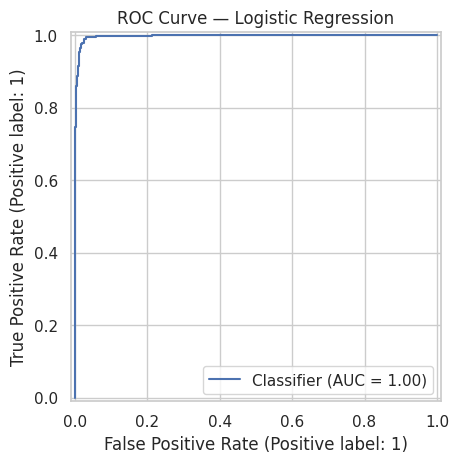

In [ ]:
lr_model = train_and_evaluate(LogisticRegression(max_iter=1000), "Logistic Regression")


 Evaluation: Random Forest
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1760    0]
 [   0 1760]]
AUC-ROC: 1.0000


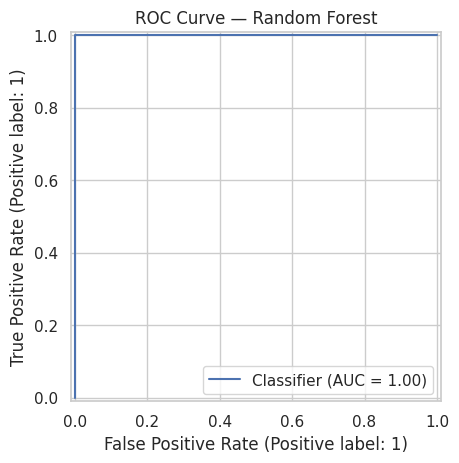

In [ ]:
rf_model = train_and_evaluate(RandomForestClassifier(n_estimators=100), "Random Forest")

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [15:53:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Evaluation: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1760    0]
 [   0 1760]]
AUC-ROC: 1.0000


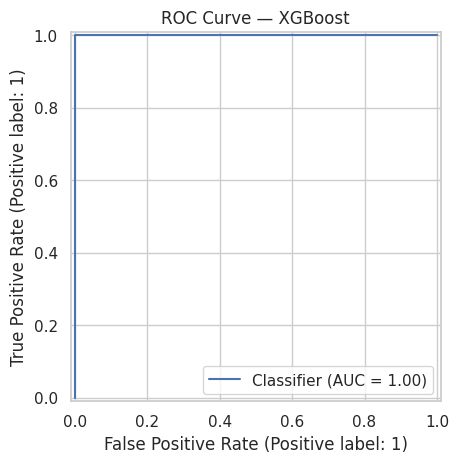

In [ ]:
xgb_model = train_and_evaluate(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), "XGBoost")

In [ ]:
def evaluate_on_validation(model, name):
    y_val_pred = model.predict(X_val)
    y_val_proba = model.predict_proba(X_val)[:, 1]

    print(f"\n Validation: {name}")
    print(classification_report(y_val, y_val_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_val_pred))
    print(f"AUC-ROC: {roc_auc_score(y_val, y_val_proba):.4f}")

In [ ]:
evaluate_on_validation(xgb_model, "XGBoost")


 Validation: XGBoost
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1760
           1       1.00      1.00      1.00      1760

    accuracy                           1.00      3520
   macro avg       1.00      1.00      1.00      3520
weighted avg       1.00      1.00      1.00      3520

Confusion Matrix:
[[1760    0]
 [   0 1760]]
AUC-ROC: 1.0000


In [ ]:
joblib.dump(xgb_model, "/content/ml_model.pkl")
print("Model saved as ml_model.pkl")

Model saved as ml_model.pkl


<Axes: xlabel='Importance', ylabel='Feature'>

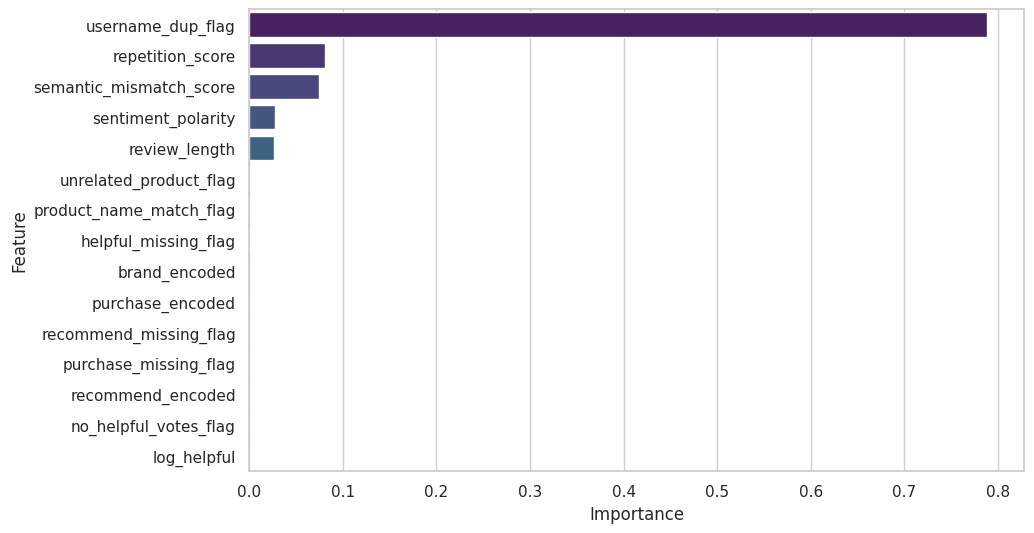

In [ ]:
importances = xgb_model.feature_importances_
feature_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_df.head(15),
    hue='Feature',  # Explicitly assign hue
    palette='viridis',
    dodge=False,    # Prevent splitting bars by hue
    legend=False    # Hide duplicate legend
)
